#                   Sentiment Analisys
#                        Ilan Moshe (024176398)
                

## In the Fine_Tune_LLM_Model file I do the following steps:



####*   Load a basic distilbert model ( that is a compromize between performance and computation requierments )
####*   Evaluate the model perfoamce
####*   Fine tune the model on IDMB customer sentiment dataset to acheive better performance
####*   Verify the model performance after the fine tuning training



(Utilizing the DistilBERT model from Hugging Face for sentiment analysis leverages the power of a streamlined, efficient version of BERT to classify text sentiment with remarkable accuracy and speed. DistilBERT, a distilled version of BERT, maintains 97% of BERT's language understanding while being 60% faster and 40% smaller, making it ideal for sentiment analysis tasks where computational efficiency is crucial. To further enhance the model's performance, large language model (LLM) fine-tuning can be performed. This process involves training DistilBERT on a task-specific dataset, allowing the model to learn the nuances and intricacies of the specific sentiment analysis application, thereby improving its accuracy and robustness in real-world scenarios )



## Packege Installation

In [1]:
!pip install datasets peft transformers evaluate torch accelerate gdown

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

### Import Packaged

In [2]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import re as re
import pandas as pd
import gdown
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Dowload data from GIT and google drive


*   Download the CSV used for model training
*   Download the CSV used for model performace testing



In [48]:
# Download the file from google drive used to test the model performance
gdown.download(f'https://drive.google.com/file/d/1ckVZiUef9tCyZCIhTqYgziMjZ-r0NKw6/view?usp=drive_link', 'Model_Test_csv.csv', quiet=False , fuzzy = True)

# Download the file from google drive used to train the model performance
gdown.download(f'https://drive.google.com/file/d/1Gg6rpq-cOADYGtokMkuaEJV0QS7kkHK1/view?usp=drive_link', 'IMDB_Dataset_update.csv', quiet=False , fuzzy = True)

Downloading...
From: https://drive.google.com/uc?id=1ckVZiUef9tCyZCIhTqYgziMjZ-r0NKw6
To: /content/Model_Test_csv.csv
100%|██████████| 627k/627k [00:00<00:00, 77.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gg6rpq-cOADYGtokMkuaEJV0QS7kkHK1
To: /content/IMDB_Dataset_update.csv
100%|██████████| 66.3M/66.3M [00:00<00:00, 199MB/s]


'IMDB_Dataset_update.csv'

In [4]:
df = pd.read_csv('/content/IMDB_Dataset_update.csv')
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Clean the dataset from redundent charecters

In [5]:
# Function to apply the mapping to the dataset
def encode_label(example):
    example['label'] = label_mapping[example['label']]
    return example

def clean_text(text):
    import re
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

In [6]:
df['text']=df['text'].apply(lambda cw : clean_text(cw))
df.head()

,text,label
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


## Create the dataset from the DataFrame and encodes the labels from strings to integers, splits the dataset into training and validation sets with a 50-50 ratio

In [7]:
from datasets import load_dataset, DatasetDict , Dataset

# Load the dataset
dataset_idmb = Dataset.from_pandas(df)
# Define the mapping from string labels to integers
label_mapping = {'positive': 1, 'negative': 0}

# Apply the mapping to the dataset
encoded_dataset = dataset_idmb.map(encode_label)

# Split the dataset into training (50%) and validation (50%)
split_dataset = encoded_dataset.train_test_split(test_size=0.5)

# Combine the splits into a DatasetDict
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test']
})

# Verify the splits and the label encoding
dataset = final_dataset
print(dataset)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})


## Calculate the proportion of positive labels in the training dataset.

In [8]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.50008

### Define a DistilBERT model checkpoint for sequence classification, defines mappings between label IDs and their string representations, and initializes a classification model with these configurations using the specified model checkpoint.

In [9]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Display the model architecture

In [10]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Initialize a tokenizer from the specified model checkpoint, adds a padding token if it doesn't already exist, and adjusts the model's token embeddings to accommodate the updated tokenizer.

In [11]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Define a function that extracts text from examples, sets the tokenizer to truncate from the left, and tokenizes the text with a maximum length of 512 tokens, returning the tokenized inputs in NumPy array format.

In [12]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [13]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

### Initializes a `DataCollatorWithPadding` object using the specified tokenizer, which will handle dynamic padding of input sequences during batching.

In [14]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### evaluation

In [15]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [16]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

### Test the basic model untrained model with sample text to see if the model performs correctly or it need to be fine tuned

In [17]:
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Negative
Not a fan, don't recommed. - Negative
Better than the first one. - Negative
This is not worth watching even once. - Negative
This one is a pass. - Negative


## We see that the basic model is not performing well on the sample imput and it needs to be find tuned

# Fine Tune the basic model by Training it with new data

### Create a `LoraConfig` object for fine-tuning a sequence classification model using Low-Rank Adaptation (LoRA) with specific parameters such as rank (`r`), alpha (`lora_alpha`), dropout rate (`lora_dropout`), and target modules (`target_modules`).

In [18]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [19]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

### Apply the PEFT (Parameter-Efficient Fine-Tuning) configuration to the model and prints the trainable parameters to review which parts of the model are updated during training.

In [20]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9307


### Define the training arguments for model fine-tuning, specifying parameters such as output directory, learning rate, batch sizes, number of epochs, weight decay, evaluation and saving strategies, and ensuring the best model is loaded at the end of training.

In [21]:
# Define hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 5 # Trainig is very computation bound , so i run only 5 epocs

In [22]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

### Initialize a `Trainer` object with the model, training arguments, datasets, tokenizer, data collator for dynamic padding, and metrics computation, and then trains the model using this setup.

In [23]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.501300,0.522420,{'accuracy': 0.84908}
2,0.451200,0.685816,{'accuracy': 0.84684}


Trainer is attempting to log a value of "{'accuracy': 0.84908}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.84684}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.501300,0.522420,{'accuracy': 0.84908}
2,0.451200,0.685816,{'accuracy': 0.84684}
3,0.437900,0.447783,{'accuracy': 0.86352}
4,0.417900,0.421824,{'accuracy': 0.87016}
5,0.365400,0.432281,{'accuracy': 0.87556}


Trainer is attempting to log a value of "{'accuracy': 0.86352}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.87016}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.87556}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=31250, training_loss=0.44270025830078125, metrics={'train_runtime': 5414.9248, 'train_samples_per_second': 23.084, 'train_steps_per_second': 5.771, 'total_flos': 1.2509757318694272e+16, 'train_loss': 0.44270025830078125, 'epoch': 5.0})

# Performance Remark -


---


## The perofmace could be better improved with more epocs , but due to the abcense of GPU usage (It costs money , and I wanted  to avoid it ) , i ran only 5 ecpocs. We can see that training is improving the accuracy and reduced the loss with every epoc

## Generate prediction after model training on same input as before

In [24]:
model.to('cpu') # moving to mps for Mac (can alternatively do 'cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
It was good. - Positive
Not a fan, don't recommed. - Negative
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive


## Save the model , zip it and donwload

In [25]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.txt',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

In [26]:
# Save id2label and label2id
import json
with open('/content/fine_tuned_model/id2label.json', 'w') as f:
    json.dump(id2label, f)
with open('/content/fine_tuned_model/label2id.json', 'w') as f:
    json.dump(label2id, f)

In [27]:
import shutil
from google.colab import files

# Path to the directory containing your model
model_dir = '/content/fine_tuned_model'

# Zip the directory
shutil.make_archive(model_dir, 'zip', model_dir)

# Download the zipped file
files.download(f'{model_dir}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate the performace of the model on different Test dataset

Read the test file dataset

In [42]:
import pandas as pd

encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

# Load the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv('/content/Model_Test_csv.csv', encoding=encoding ,  on_bad_lines='warn')
        print(f"Successfully read the file with {encoding} encoding.")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read with {encoding} encoding. Error: {e}")

# Display the first few rows of the DataFrame
df.head()

Successfully read the file with utf-8 encoding.


,text,label
0,I always wrote this series off as being a comp...,negative
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,negative
2,This movie was so poorly written and directed ...,negative
3,The most interesting thing about Miryang (Secr...,positive
4,"when i first read about ""berlin am meer"" i did...",negative


In [44]:
verify_text = df['text'].tolist()
verify_score = df['label'].tolist()

In [43]:
df['text']=df['text'].apply(lambda cw : clean_text(cw))
df.head()

,text,label
0,i always wrote this series off as being a comp...,negative
1,st watched out of dirsteve purcell typical ...,negative
2,this movie was so poorly written and directed ...,negative
3,the most interesting thing about miryang secre...,positive
4,when i first read about berlin am meer i didnt...,negative


 Display numer of possitive and negative values in test dataset

In [56]:
df['label'].value_counts()

label
negative    266
positive    233
Name: count, dtype: int64

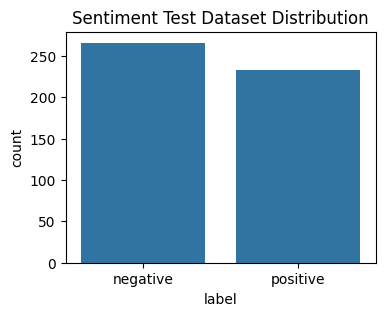

In [61]:
plt.figure(figsize=(4, 3))
sns.countplot(x='label', data=df)
plt.title('Sentiment Test Dataset Distribution')
plt.show()

In [45]:
sentiment_mapping = {'positive': 1, 'negative': 0}

# Convert the list using list comprehension and the mapping dictionary
verify_score = [sentiment_mapping[sentiment] for sentiment in verify_score]


### perform prediction on the new test records

In [46]:
texts = verify_text
predictions = []

# Tokenize the input texts
for text in texts:

  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

  # Run the model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get the logits and convert to probabilities (optional)
  logits = outputs.logits
  probs = torch.nn.functional.softmax(logits, dim=-1)
  predictions.append(torch.argmax(logits, dim=-1).item())

# Get the predicted class indices
print(predictions)


[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 

## Plot the  roc_curve , confusion_matrix and classification_report

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       266
           1       0.88      0.88      0.88       233

    accuracy                           0.88       499
   macro avg       0.88      0.88      0.88       499
weighted avg       0.88      0.88      0.88       499



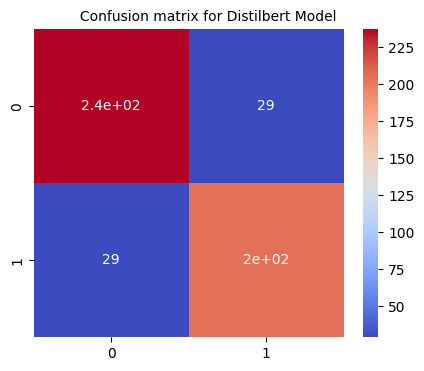

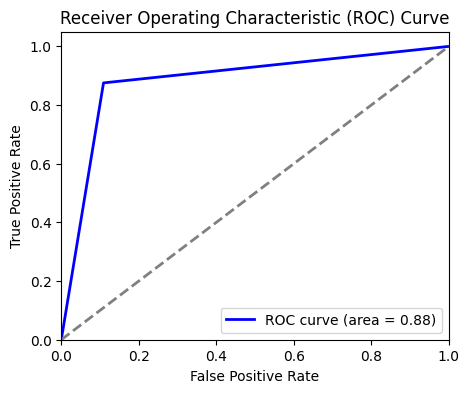

In [65]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score , roc_curve , roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = predictions
y_true = verify_score

# display confution matrix
cfg_dist = confusion_matrix(y_true, y_pred)
plt.figure(1 , figsize = (5,4))
plt.title('             Confusion matrix for Distilbert Model    ' , fontsize = 10)
sns.heatmap(cfg_dist , annot = True , cmap = 'coolwarm')

# print classification_report
print(classification_report(y_true, y_pred))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Compute AUC
auc = roc_auc_score(y_true, y_pred)

# Plot ROC curve
plt.figure(2 , figsize = (5,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Summarizing:

---





###*   We see that the perofmace is equaivalent to the performance seein during model training (~88% accuracy)
###*   The perofmace could be better improved with more epocs , but due to the abcense of GPU usage (It costs money , and I wanted to avoid it ) , i ran only 5 ecpocs . In addtion I have used a large dataset with 50000 record.
###*   Confusion matrix performance support theh results with most results on the main diagonal
###*   distilbert is a reduced performace version to start with , but we see that we can get good performance with it even with few epocs





